<a href="https://colab.research.google.com/github/AShah1111/Blueprint-Power-Interview-Project/blob/master/Blueprint_Power_Interview_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving NYISO LBMPS.csv to NYISO LBMPS.csv
User uploaded file "NYISO LBMPS.csv" with length 6913135 bytes


In [0]:
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot
%matplotlib inline
import statsmodels.api as sm
from sklearn import preprocessing
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout



In [0]:
#Import data and conduct EDA
data = pd.read_csv('NYISO LBMPS.csv')


In [229]:
data.head()

Unnamed: 0        Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0           0  01/01/2017 00:00  CAPITL  61757          42.06   
1           1  01/01/2017 00:00  CENTRL  61754          15.50   
2           2  01/01/2017 00:00  DUNWOD  61760          33.52   
3           3  01/01/2017 00:00  GENESE  61753          14.67   
4           4  01/01/2017 00:00     H Q  61844          11.89   

   Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                           0.68                             -29.05  
1                           0.20                              -2.98  
2                           1.13                             -20.06  
3                           0.04                              -2.31  
4                          -0.43                               0.00

In [230]:
data.shape

(131400, 7)

In [110]:
data.tail()

Unnamed: 0        Time Stamp   Name   PTID  LBMP ($/MWHr)  \
131395      131395  12/31/2017 23:00  NORTH  61755          63.96   
131396      131396  12/31/2017 23:00    NPX  61845         129.42   
131397      131397  12/31/2017 23:00    O H  61846          68.16   
131398      131398  12/31/2017 23:00    PJM  61847          84.43   
131399      131399  12/31/2017 23:00   WEST  61752          68.99   

        Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
131395                          -0.58                               0.00  
131396                           4.90                             -59.98  
131397                          -4.97                              -8.59  
131398                           1.42                             -18.47  
131399                          -3.81                              -8.26

In [231]:
data.isnull().any()

Unnamed: 0                           False
Time Stamp                           False
Name                                 False
PTID                                 False
LBMP ($/MWHr)                        False
Marginal Cost Losses ($/MWHr)        False
Marginal Cost Congestion ($/MWHr)    False
dtype: bool

In [232]:
data.dtypes

Unnamed: 0                             int64
Time Stamp                            object
Name                                  object
PTID                                   int64
LBMP ($/MWHr)                        float64
Marginal Cost Losses ($/MWHr)        float64
Marginal Cost Congestion ($/MWHr)    float64
dtype: object

In [233]:
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], infer_datetime_format=True)
data.head()

Unnamed: 0 Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0           0 2017-01-01  CAPITL  61757          42.06   
1           1 2017-01-01  CENTRL  61754          15.50   
2           2 2017-01-01  DUNWOD  61760          33.52   
3           3 2017-01-01  GENESE  61753          14.67   
4           4 2017-01-01     H Q  61844          11.89   

   Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                           0.68                             -29.05  
1                           0.20                              -2.98  
2                           1.13                             -20.06  
3                           0.04                              -2.31  
4                          -0.43                               0.00

In [0]:
#Drop unwanted columns
data = data.drop("Unnamed: 0", axis = 1)


In [0]:
#Set Time Stamp as index
data = data.set_index('Time Stamp')


In [0]:
data_model = data.drop("Name", axis = 1 )


In [0]:
data_model = data_model.drop("PTID", axis = 1)

In [238]:
#Cleaned data for creating model
data_model.head()

LBMP ($/MWHr)  Marginal Cost Losses ($/MWHr)  \
Time Stamp                                                 
2017-01-01          42.06                           0.68   
2017-01-01          15.50                           0.20   
2017-01-01          33.52                           1.13   
2017-01-01          14.67                           0.04   
2017-01-01          11.89                          -0.43   

            Marginal Cost Congestion ($/MWHr)  
Time Stamp                                     
2017-01-01                             -29.05  
2017-01-01                              -2.98  
2017-01-01                             -20.06  
2017-01-01                              -2.31  
2017-01-01                               0.00

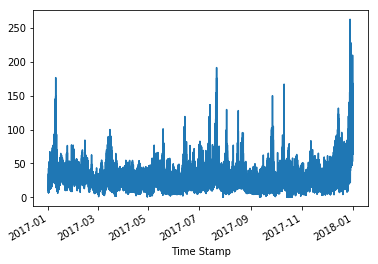

In [239]:
#Plot distribution of LBMP
data['LBMP ($/MWHr)'].plot()



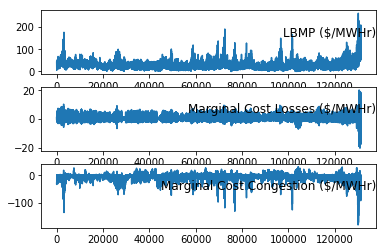

In [240]:
#Plot distribution of the three variables that will be used to create model
from matplotlib import pyplot
values = data.values
# specify columns to plot
groups = [2,3,4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


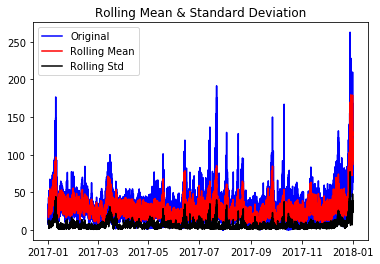

Results of Dickey-Fuller Test:
Test Statistic                -1.634682e+01
p-value                        2.958847e-29
#Lags Used                     7.300000e+01
Number of Observations Used    1.313260e+05
Critical Value (1%)           -3.430400e+00
Critical Value (5%)           -2.861562e+00
Critical Value (10%)          -2.566782e+00
dtype: float64


In [262]:
#Plot rolling mean, standard deviation and original data for LBMP and perform Dickey-Fuller test to determine if this time series is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(data['LBMP ($/MWHr)'])

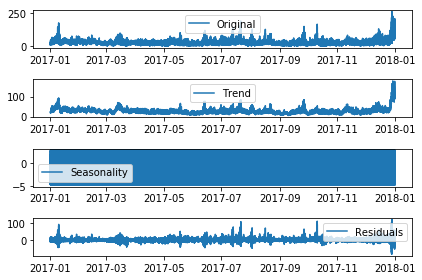

In [243]:
#Plot seasonal distribution of LBMP to confirm there is no seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = sm.tsa.seasonal_decompose(data['LBMP ($/MWHr)'], model = 'additive', freq = 12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(lbmp, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
#Function to convert data to a form that can be used for supervised learning in a neural network
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg
 

In [245]:
#Take values from data into array
values = data_model.values
len(values)
data_model.head()

LBMP ($/MWHr)  Marginal Cost Losses ($/MWHr)  \
Time Stamp                                                 
2017-01-01          42.06                           0.68   
2017-01-01          15.50                           0.20   
2017-01-01          33.52                           1.13   
2017-01-01          14.67                           0.04   
2017-01-01          11.89                          -0.43   

            Marginal Cost Congestion ($/MWHr)  
Time Stamp                                     
2017-01-01                             -29.05  
2017-01-01                              -2.98  
2017-01-01                             -20.06  
2017-01-01                              -2.31  
2017-01-01                               0.00

In [0]:
#Make sure all data is of float type
values = values.astype('float32')


In [0]:
#Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [0]:
#Reframe data as supervised learning

reframed = series_to_supervised(scaled, 1, 1)


In [249]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
0        NaN        NaN        NaN  0.160119  0.516762  0.715300
1   0.160119   0.516762   0.715300  0.059007  0.504842  0.837838
2   0.059007   0.504842   0.837838  0.127608  0.527936  0.757556
3   0.127608   0.527936   0.757556  0.055847  0.500869  0.840987
4   0.055847   0.500869   0.840987  0.045264  0.489198  0.851845

In [250]:
#Drop variables that are not going to be forecasted
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
0        NaN        NaN        NaN  0.160119
1   0.160119   0.516762   0.715300  0.059007
2   0.059007   0.504842   0.837838  0.127608
3   0.127608   0.527936   0.757556  0.055847
4   0.055847   0.500869   0.840987  0.045264


In [251]:
#Drop first row as it contains NaNs
reframed.drop(reframed.index[0],inplace = True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.160119   0.516762   0.715300  0.059007
2   0.059007   0.504842   0.837838  0.127608
3   0.127608   0.527936   0.757556  0.055847
4   0.055847   0.500869   0.840987  0.045264
5   0.045264   0.489198   0.851845  0.127988

In [252]:
#Split into train and test sets
values = reframed.values
n_train_hours = int(2/3*len(values))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(87599, 1, 3) (87599,) (43800, 1, 3) (43800,)


Train on 87599 samples, validate on 43800 samples
Epoch 1/100
 - 7s - loss: 0.0303 - val_loss: 0.0352
Epoch 2/100
 - 4s - loss: 0.0259 - val_loss: 0.0280
Epoch 3/100
 - 4s - loss: 0.0243 - val_loss: 0.0256
Epoch 4/100
 - 4s - loss: 0.0238 - val_loss: 0.0250
Epoch 5/100
 - 4s - loss: 0.0236 - val_loss: 0.0248
Epoch 6/100
 - 4s - loss: 0.0234 - val_loss: 0.0246
Epoch 7/100
 - 4s - loss: 0.0232 - val_loss: 0.0242
Epoch 8/100
 - 4s - loss: 0.0230 - val_loss: 0.0238
Epoch 9/100
 - 4s - loss: 0.0229 - val_loss: 0.0236
Epoch 10/100
 - 4s - loss: 0.0228 - val_loss: 0.0233
Epoch 11/100
 - 4s - loss: 0.0226 - val_loss: 0.0231
Epoch 12/100
 - 4s - loss: 0.0225 - val_loss: 0.0229
Epoch 13/100
 - 4s - loss: 0.0224 - val_loss: 0.0227
Epoch 14/100
 - 4s - loss: 0.0223 - val_loss: 0.0225
Epoch 15/100
 - 4s - loss: 0.0223 - val_loss: 0.0224
Epoch 16/100
 - 4s - loss: 0.0222 - val_loss: 0.0223
Epoch 17/100
 - 4s - loss: 0.0222 - val_loss: 0.0223
Epoch 18/100
 - 4s - loss: 0.0221 - val_loss: 0.0222
Epoch

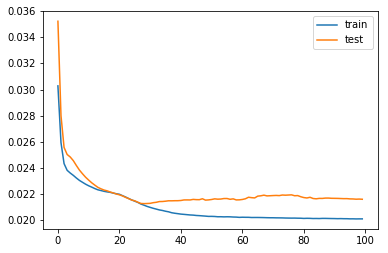

In [253]:
#Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#Plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [139]:
yhat.shape

(43800, 1)

In [255]:
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt

#Predict new values
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 11.673


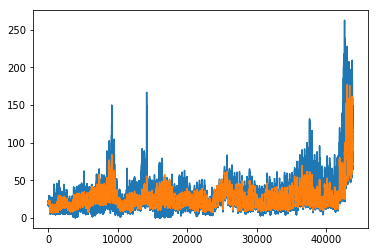

In [277]:
#Plot predicted values in orange against actualy values in blue
plt.plot(inv_y)
plt.plot(inv_yhat)

In [257]:
#Take subset of data for August 1st 2017
one_day = data_model.loc['2017-08-01':'2017-08-01']
one_day.shape


(360, 3)

In [222]:
one_day.head()

LBMP ($/MWHr)  Marginal Cost Losses ($/MWHr)  \
Time Stamp                                                 
2017-08-01          19.31                           0.17   
2017-08-01          21.38                           2.24   
2017-08-01          18.99                          -0.15   
2017-08-01          18.43                          -0.71   
2017-08-01          21.21                           2.07   

            Marginal Cost Congestion ($/MWHr)  forecast  
Time Stamp                                               
2017-08-01                                0.0  1.717128  
2017-08-01                                0.0  1.533435  
2017-08-01                                0.0  1.888378  
2017-08-01                                0.0  1.478408  
2017-08-01                                0.0  1.381996

In [258]:
#Load dataset
values_one_day = one_day.values
len(values)

#Ensure all data is float
values_one_day = values_one_day.astype('float32')

#Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_one_day = scaler.fit_transform(values_one_day)
reframed_one_day = series_to_supervised(scaled_one_day, 1, 1)
reframed_one_day.drop(reframed_one_day.columns[[4,5]], axis=1, inplace=True)
print(reframed_one_day.head())
reframed_one_day.drop(reframed_one_day.index[0],inplace = True)
reframed_one_day.head()

#Split into train and test sets
values_one_day = reframed_one_day.values


#Split into input and outputs
one_day_X, one_day_y = values_one_day[:, :-1], values_one_day[:, -1]

#Reshape input to be 3D [samples, timesteps, features]
one_day_X = one_day_X.reshape((one_day_X.shape[0], 1, one_day_X.shape[1]))


yhat_one_day = model.predict(one_day_X)
one_day_X = one_day_X.reshape((one_day_X.shape[0], one_day_X.shape[2]))

inv_yhat_one_day = concatenate((yhat_one_day, one_day_X[:, 1:]), axis=1)
inv_yhat_one_day = scaler.inverse_transform(inv_yhat_one_day)
inv_yhat_one_day = inv_yhat_one_day[:,0]

#Invert scaling for actual
one_day_y = one_day_y.reshape((len(one_day_y), 1))
inv_y_one_day = concatenate((one_day_y, one_day_X[:, 1:]), axis=1)
inv_y_one_day = scaler.inverse_transform(inv_y_one_day)
inv_y_one_day = inv_y_one_day[:,0]




   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
0        NaN        NaN        NaN  0.162156
1   0.162156   0.576555        1.0  0.150756
2   0.150756   0.320574        1.0  0.172811
3   0.172811   0.815790        1.0  0.147347
4   0.147347   0.244019        1.0  0.141381


In [259]:
#Merge forecasted values with August 1st subset
one_day = one_day.iloc[1:,]
one_day['forecast'] = inv_yhat_one_day
one_day.shape

(359, 4)

In [264]:
#Calculate mean of LBMP
data["LBMP ($/MWHr)"].mean()

27.648274048705936

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


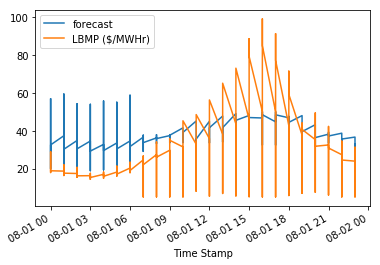

In [261]:
#Plot forecasted and actual LBMP for August 1st 
one_day.plot(y=["forecast", "LBMP ($/MWHr)"])
